In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

import matplotlib.pyplot as plt
from keras.utils import to_categorical

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("../input/movie-review-sentiment-analysis-kernels-only"))
print(os.listdir("../input/word2vec-google"))
print(os.listdir("../input/fasttext-english-word-vectors-including-subwords"))

np.random.seed(0)
random.seed(0)

pd.set_option('display.max_colwidth', -1)

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['movie-review-sentiment-analysis-kernels-only', 'word2vec-google', 'fasttext-english-word-vectors-including-subwords']
['train.tsv', 'test.tsv', 'sampleSubmission.csv']
['GoogleNews-vectors-negative300.bin']
['wiki-news-300d-1M-subword.vec']


In [2]:
data = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/train.tsv', sep='\t')

train = data[['PhraseId','SentenceId','Phrase']]
labels = data[['Sentiment']]
print(train.shape)
print(labels.shape)

(156060, 3)
(156060, 1)


In [3]:
# preprocess text data
import re

def preprocess(text):
    words = []
    split = re.compile(r"[^a-z0-9']")
    digit = re.compile(r'^\d')
    alpha = re.compile(r'[a-z]')
    
    contractions = {
        "n't": 'not',
        "'d": 'would',
        "'re": 'are',
        "'ll": 'will',
        "'s": 'has',
        "'m": 'am',
        "'ve": 'have'
    }
    
    for w in split.split(text.lower()):
        if w.isspace():
            continue
        if w == '':
            continue
        if w in contractions:
            w = contractions[w]
        if digit.match(w):
            continue
        if not alpha.match(w):
            continue

        words.append(w)
            
    return ' '.join(words)

train['CleanedPhrase'] = train['Phrase'].apply(preprocess)
train.head()

,PhraseId,SentenceId,Phrase,CleanedPhrase
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,a series of escapades demonstrating the adage that what is good for the goose
2,3,1,A series,a series
3,4,1,A,a
4,5,1,series,series


In [4]:
# determine which records are full sentences
train['Tokens'] = train['CleanedPhrase'].str.split(' ').str.len()
sentences = train.groupby('SentenceId', sort=False)['Tokens'].transform(max) == train['Tokens']
train['Full'] = sentences

In [5]:
train[train.Full].head(10)

,PhraseId,SentenceId,Phrase,CleanedPhrase,Tokens,Full
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story,35,True
63,64,2,"This quiet , introspective and entertaining independent is worth seeking .",this quiet introspective and entertaining independent is worth seeking,9,True
81,82,3,"Even fans of Ismail Merchant 's work , I suspect , would have a hard time sitting through this one .",even fans of ismail merchant has work i suspect would have a hard time sitting through this one,18,True
116,117,4,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera .",a positively thrilling combination of ethnography and all the intrigue betrayal deceit and murder of a shakespearean tragedy or a juicy soap opera,23,True
117,118,4,"A positively thrilling combination of ethnography and all the intrigue , betrayal , deceit and murder of a Shakespearean tragedy or a juicy soap opera",a positively thrilling combination of ethnography and all the intrigue betrayal deceit and murder of a shakespearean tragedy or a juicy soap opera,23,True
156,157,5,Aggressive self-glorification and a manipulative whitewash .,aggressive self glorification and a manipulative whitewash,7,True
157,158,5,Aggressive self-glorification and a manipulative whitewash,aggressive self glorification and a manipulative whitewash,7,True
166,167,6,A comedy-drama of nearly epic proportions rooted in a sincere performance by the title character undergoing midlife crisis .,a comedy drama of nearly epic proportions rooted in a sincere performance by the title character undergoing midlife crisis,19,True
198,199,7,"Narratively , Trouble Every Day is a plodding mess .",narratively trouble every day is a plodding mess,8,True
213,214,8,"The Importance of Being Earnest , so thick with wit it plays like a reading from Bartlett 's Familiar Quotations",the importance of being earnest so thick with wit it plays like a reading from bartlett has familiar quotations,19,True


In [6]:
def calculate_class_weights(labels):
    counts = np.bincount(labels)
    largest = np.max(counts)

    w = {}
    for label, count in enumerate(counts):
        w[label] = largest/count

    print('Weights:')
    for cls, weight in w.items():
        print('%d: %0.6f' % (cls, weight))

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.20)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50)

y_train = y_train['Sentiment'].values
y_test = y_test['Sentiment'].values
y_val = y_val['Sentiment'].values

n_classes = len(np.unique(y_train))

print('Classes: ', n_classes)
print('Training size: %s, %s' % (X_train.shape, y_train.shape))
print('Testing size: %s, %s' % (X_test.shape, y_test.shape))
print('Validation size: %s, %s' % (X_val.shape, y_val.shape))

Classes:  5
Training size: (124848, 6), (124848,)
Testing size: (15606, 6), (15606,)
Validation size: (15606, 6), (15606,)


In [8]:
weights = calculate_class_weights(y_train)

Weights:
0: 11.422414
1: 2.914757
2: 1.000000
3: 2.401269
4: 8.624898


In [9]:
def plot_history(history, name):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model %s accuracy' % name)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model %s loss' % name)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def train_model(name, model, x_train, y_train, x_test, y_test, x_val, y_val,
                batch_size=32, epochs=10, callbacks=[], class_weight=weights, categorical=True, initial_epoch=0, save=True):
    if categorical:
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
        y_val = to_categorical(y_val)
        
    history = model.fit(x_train,
          batch_size=batch_size, 
          y=y_train,
          verbose=1,
          shuffle=True, 
          epochs=epochs, 
          validation_data=(x_test, y_test),
          class_weight=class_weight,
          callbacks=callbacks,
          initial_epoch=initial_epoch)

    if save:
        model.save('%s.h5' % name)
        
    plot_history(history, name)
    scores = model.evaluate(x_val, y_val)

    print('validation scores for %s' % name)
    for i, score in enumerate(scores):
        name = model.metrics_names[i]
        print('%s score: %0.6f' % (name, score))
    
    return history

In [10]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# cv = CountVectorizer()
# cv.fit(X_train['CleanedPhrase'])

# tv = TfidfVectorizer()
# tv.fit(X_train['CleanedPhrase'])

# x_train = tv.transform(X_train['CleanedPhrase'])
# x_test = tv.transform(X_test['CleanedPhrase'])
# x_val = tv.transform(X_val['CleanedPhrase'])

# print('Items in training vocabulary (CountVectorizer): ', len(cv.vocabulary_))
# print('Items in training vocabulary (TfidfVectorizer): ', len(tv.vocabulary_))

#vocab_length = len(cv.vocabulary_)

In [11]:
from keras.layers import Input, Dense, Embedding, Flatten, Dropout, LSTM, GRU, RNN, Bidirectional
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import SpatialDropout1D, BatchNormalization
from keras.initializers import Constant

In [12]:
seq_max_length=50

def create_sequences(tokenizer, *inputs, **kwargs):
    maxlen = kwargs.get('maxlen', seq_max_length)
    padding = kwargs.get('padding', 'pre')
    fit = kwargs.get('fit', True)
    
    if fit:
        tokenizer.fit_on_texts(inputs[0])
    
    seqs = []
    for input in inputs:
        seq = tokenizer.texts_to_sequences(input)
        seq = pad_sequences(seq, maxlen=maxlen, padding=padding)
        seqs.append(seq)
    
    return seqs

In [13]:
tokenizer = Tokenizer(filters='', lower=True)
(train_seq, test_seq, val_seq) = create_sequences(tokenizer,
                                                  X_train['CleanedPhrase'],
                                                  X_test['CleanedPhrase'], 
                                                  X_val['CleanedPhrase'],
                                                  padding='post', fit=True)

print(train_seq.shape)
print(test_seq.shape)
print(val_seq.shape)

(124848, 50)
(15606, 50)
(15606, 50)


In [ ]:
# X_full_train = X_train[X_train.Full]
# y_full_train = y_train[X_train.Full]

# X_full_test = X_test[X_test.Full]
# y_full_test = y_test[X_test.Full]

# X_full_val = X_val[X_val.Full]
# y_full_val = y_val[X_val.Full]

# print(X_full_train.shape)
# print(X_full_test.shape)
# print(X_full_val.shape)

In [ ]:
# full_tokenizer = Tokenizer()
# (full_train_seq, full_test_seq, full_val_seq) = \
#     create_sequences(full_tokenizer,
#                      X_full_train['CleanedPhrase'],
#                      X_full_test['CleanedPhrase'],
#                      X_full_val['CleanedPhrase'],
#                      padding='post', fit=True)

# print(full_train_seq.shape)
# print(full_test_seq.shape)
# print(full_val_seq.shape)

In [ ]:
# full_weights = calculate_class_weights(y_full_train)

In [ ]:
# def build_model_v1(vocab_size, n_classes=n_classes, loss='categorical_crossentropy', optimizer='adam', metrics=['acc']):
#     inputs = Input(shape=(vocab_size, ), name='input')
    
#     x = Dense(5000, name='dense1', activation='relu')(inputs)
#     x = Dropout(0.6)(x)
#     x = Dense(1000, name='dense2', activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(100, name='dense3', activation='relu')(x)
#     x = Dropout(0.3)(x)
#     x = Dense(n_classes, name='dense4', activation='softmax')(x)
    
#     model = Model(inputs=inputs, outputs=x)
#     model.compile(optimizer=optimizer,
#                   loss=loss,
#                   metrics=metrics)
    
#     return model

# model1 = build_model_v1(len(cv.vocabulary_), n_classes=n_classes)
# model1.summary()

# train_model('model1', model1, x_train, y_train, x_test, y_test, x_val, y_val)

In [ ]:
# def build_model_v2(vocab_size, max_length, embedding_output_dims=100, n_classes=n_classes, loss='categorical_crossentropy', optimizer='adam', metrics=['acc']):
#     inputs = Input(shape=(max_length,))
    
#     x = Embedding(vocab_size, embedding_output_dims, input_length=max_length)(inputs)
#     x = Flatten()(x)
#     x = Dense(1000, activation='relu')(x)
#     x = Dropout(0.8)(x)
#     x = Dense(500, activation='relu')(x)
#     x = Dropout(0.8)(x)
#     x = Dense(100, activation='relu')(x)
#     x = Dropout(0.8)(x)
#     x = Dense(n_classes, activation='softmax')(x)

#     model = Model(inputs=[inputs], outputs=x)
#     model.compile(optimizer=optimizer,
#                   loss=loss,
#                   metrics=metrics)
    
#     return model

# model2 = build_model_v2(len(tokenizer.word_index), seq_max_length)
# model2.summary()

# train_model('model2', model2, train_seq, y_train, test_seq, y_test, val_seq, y_val)

In [ ]:
# def build_model_v3(vocab_size, max_length, lstm_hidden_size=100, embedding_output_dims=100, n_classes=n_classes, loss='categorical_crossentropy', optimizer='adam', metrics=['acc']):
#     inputs = Input(shape=(max_length,))
    
#     x = Embedding(vocab_size, embedding_output_dims, input_length=max_length)(inputs)
#     x = LSTM(lstm_hidden_size, dropout=0.6, recurrent_dropout=0.6, return_sequences=False)(x)
#     x = Dense(n_classes, activation='softmax')(x)

#     model = Model(inputs=[inputs], outputs=x)
#     model.compile(optimizer=optimizer,
#                   loss=loss,
#                   metrics=metrics)
    
#     return model

# model3 = build_model_v3(vocab_length, max_length)
# model3.summary()

# train_model('model3', model3, train_seq, y_train, test_seq, y_test, val_seq, y_val)

In [ ]:
# def predict_v1(text):
#     input = cv.transform([text])
#     output = model.predict(input)
#     predicted = np.argmax(output)
#     return ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'][predicted]
    
# predict_v1('It had a lot of humor.')

In [ ]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.models.wrappers import FastText

# word2vec
from gensim.models.keyedvectors import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('../input/word2vec-google/GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
embedding_dims = 300

def get_embedding_matrix(tokenier, dims=embedding_dims, random_unknowns=True):
    vocab_length = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_length, dims))
    missing_words = 0
    for word, i in tokenizer.word_index.items():
        if word in word_vectors:
            embedding_vector = word_vectors[word]
            embedding_matrix[i] = embedding_vector
        else:
            missing_words += 1
            # randomly initialize a vector for unknown words
            if random_unknowns:
                embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), dims)
            #print('not in index: ', word)

    print('missing %d words' % missing_words)

    return (embedding_matrix, vocab_length)

In [ ]:
(embedding_matrix, vocab_length) = get_embedding_matrix(tokenizer)
#(full_embedding_matrix, full_vocab_length) = get_embedding_matrix(full_tokenizer)

print(embedding_matrix.shape)
#print(full_embedding_matrix.shape)
print(vocab_length)
#print(full_vocab_length)

In [ ]:
del(word_vectors)

In [ ]:
# from keras.callbacks import Callback, LearningRateScheduler
# import math

# def step_decay(initial_lr=0.001, drop=0.5, epochs_drop=10.0):
#     return lambda epoch: initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))

# class LossHistory(Callback):
#     def on_train_begin(self, logs={}):
#        self.losses = []
#        self.lr = []
 
#     def on_epoch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))
#        self.lr.append(step_decay(len(self.losses)))

In [ ]:
# def build_model_v4(vocab_size,
#                    max_length,
#                    rnn_units=100,
#                    embedding_dims=100,
#                    n_classes=n_classes,
#                    loss='categorical_crossentropy',
#                    optimizer='adam',
#                    metrics=['acc'],
#                    dropout=0,
#                    recurrent_dropout=0,
#                    embedding_weights=None,
#                    activation='softmax',
#                   rnn_type='lstm',
#                   batch_normalization=False,
#                   dense_units=512,
#                   spatial_dropout=0):
#     inputs = Input(shape=(max_length,))
    
#     trainable = True
#     initializer='uniform'
#     if embedding_weights is not None:
#         trainable = False
#         initializer=Constant(embedding_weights)
        
#     x = Embedding(vocab_size,
#                   embedding_dims,
#                   input_length=max_length,
#                   trainable=trainable,
#                   embeddings_initializer=initializer)(inputs)
    
#     if spatial_dropout > 0:
#         x = SpatialDropout1D(spatial_dropout)(x)
    
#     if rnn_type == 'lstm':
#         x = LSTM(rnn_units, return_sequences=False, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
#     elif rnn_type == 'bilstm':
#         x = Bidirectional(LSTM(rnn_units, return_sequences=False, dropout=dropout, recurrent_dropout=recurrent_dropout))(x)
#     elif rnn_type == 'gru':
#         x = GRU(rnn_units, return_sequences=False, dropout=dropout, recurrent_dropout=recurrent_dropout)(x)
    
#     if batch_normalization:
#         x = Dense(dense_units)(x)
#         x = BatchNormalization()(x)
        
#     x = Dense(n_classes, activation=activation)(x)

#     model = Model(inputs=[inputs], outputs=x)
#     model.compile(optimizer=optimizer,
#                   loss=loss,
#                   metrics=metrics)
    
#     return model

In [ ]:
# lstm_units = 100
# model4 = build_model_v4(vocab_length, max_length,
#                         rnn_units=lstm_units,
#                         embedding_dims=embedding_dims,
#                         embedding_weights=embedding_matrix)
# model4.summary()

# # loss_history = LossHistory()
# # lrate = LearningRateScheduler(step_decay)
# train_model('model4', model4, 
#             train_seq, y_train, test_seq, y_test, val_seq, y_val,
#             #full_train_seq, y_full_train, full_test_seq, y_full_test, full_val_seq, y_full_val,
#             #callbacks=[loss_history, lrate], 
#             class_weight=weights,
#             epochs=10)

In [ ]:
# model5 = build_model_v4(vocab_length, max_length,
#                         rnn_units=lstm_units,
#                         embedding_dims=embedding_dims,
#                         embedding_weights=embedding_matrix,
#                         rnn_type='gru')
# model5.summary()

# # loss_history = LossHistory()
# # lrate = LearningRateScheduler(step_decay)

# train_model('model5', model5, 
#             #train_seq, y_train, test_seq, y_test, val_seq, y_val,
#             full_train_seq, y_full_train, full_test_seq, y_full_test, full_val_seq, y_full_val,
#             #callbacks=[loss_history, lrate], 
#             class_weight=full_weights,
#             epochs=10)

In [ ]:
# model6 = build_model_v4(full_vocab_length,
#                         max_length,
#                         rnn_units=64,
#                         embedding_dims=300,
#                         embedding_weights=full_embedding_matrix,
#                         rnn_type='gru',
#                         spatial_dropout=0.7,
#                         recurrent_dropout=0.2,
#                         dropout=0.2)
# model6.summary()

# # loss_history = LossHistory()
# # lrate = LearningRateScheduler(step_decay)

# train_model('model6', model6, 
#             full_train_seq, y_full_train, full_test_seq, y_full_test, full_val_seq, y_full_val,
#             #callbacks=[loss_history, lrate], 
#             class_weight=full_weights,
#             epochs=25,
#             batch_size=25)

In [ ]:
# model7 = []
# for i in range(n_classes):
#     model = build_model_v4(full_vocab_length,
#                         max_length,
#                         rnn_units=32,
#                         embedding_dims=embedding_dims,
#                         embedding_weights=full_embedding_matrix,
#                         dropout=0.2,
#                         recurrent_dropout=0.2,
#                         rnn_type='gru',
#                         n_classes=1,
#                         loss='binary_crossentropy',
#                         activation='sigmoid')
#     model.summary()
    
#     y_tr = np.where(y_full_train == i, 1, 0)
#     y_t = np.where(y_full_test == i, 1, 0)
#     y_v = np.where(y_full_val == i, 1, 0)
    
#     class_weights = calculate_class_weights(y_tr)
    
#     loss_history = LossHistory()
#     lrate = LearningRateScheduler(step_decay)
    
#     train_model('model7.%d' % i, model, 
#             full_train_seq, y_tr, full_test_seq, y_t, full_val_seq, y_v,
#             class_weight=class_weights,
#             categorical=False,
#             callbacks=[loss_history,lrate],
#             epochs=10)
    
#     model7.append(model)
#     del(y_tr)
#     del(y_t)
#     del(y_v)

In [ ]:
# from keras.layers import Conv1D, MaxPooling1D, Flatten, LeakyReLU
# from keras import regularizers
# from keras.callbacks import ModelCheckpoint

# def build_model_v8(vocab_size, max_length,
#                    embedding_dims=100,
#                    n_classes=n_classes,
#                    dropouts=[0,0,0,0],
#                    loss='categorical_crossentropy',
#                    optimizer='adam',
#                    dense_units=100,
#                    conv_filters=[32,32],
#                    conv_kernels=[3,3],
#                    pool_sizes=[2,2],
#                    conv_padding='same',
#                    conv_regularization=None,
#                    dense_regularizations=[None,None],
#                    embedding_weights=None,
#                    metrics=['acc']):
#     inputs = Input(shape=(max_length,))
    
#     trainable = True
#     embedding_initializer = 'uniform'
#     if embedding_weights is not None:
#         trainable = False
#         embedding_initializer = Constant(embedding_weights)
    
#     x = Embedding(vocab_size, embedding_dims,
#                   input_length=max_length,
#                   trainable=trainable,
#                   embeddings_initializer=embedding_initializer)(inputs)
    
#     x = Conv1D(filters=conv_filters[0], kernel_size=conv_kernels[0], padding=conv_padding, kernel_regularizer=conv_regularization)(x)
#     x = LeakyReLU()(x)
#     x = MaxPooling1D(pool_size=pool_sizes[0])(x)
#     x = SpatialDropout1D(dropouts[0])(x)
    
#     x = Conv1D(filters=conv_filters[1], kernel_size=conv_kernels[1], padding=conv_padding, kernel_regularizer=conv_regularization)(x)
#     x = LeakyReLU()(x)
#     x = MaxPooling1D(pool_size=pool_sizes[1])(x)
#     x = SpatialDropout1D(dropouts[1])(x)
    
#     x = Flatten()(x)
#     x = Dropout(dropouts[1])(x)
#     x = Dense(dense_units, activation='sigmoid', kernel_regularizer=dense_regularizations[0])(x)
#     x = Dropout(dropouts[2])(x)
#     x = Dense(n_classes, activation='softmax', kernel_regularizer=dense_regularizations[1])(x)

#     model = Model(inputs=[inputs], outputs=x)
#     model.compile(optimizer=optimizer,
#                   loss=loss,
#                   metrics=metrics)
    
#     return model

# model8 = build_model_v8(len(tokenizer.word_index),
#                         seq_max_length,
#                         embedding_dims=128,
#                         dense_units=500,
#                         conv_regularization=regularizers.l2(0.01),
#                         dropouts=[0.7,0.7,0.7,0.5],
#                         conv_filters=[64,32],
#                         conv_kernels=[3,3])
# model8.summary()

# filepath="model8.h5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# train_model('model8', model8, 
#             train_seq, y_train, test_seq, y_test, val_seq, y_val,
#             #callbacks=[loss_history, lrate], 
#             callbacks=[checkpoint],
#             class_weight=weights,
#             epochs=10,
#             batch_size=25,
#             save=False)

In [ ]:
# def evaluate(text, true=None):
#     if isinstance(text, str):
#         df = pd.DataFrame([[text]], columns=['text'])
#         text = df.text
    
#     text = text.apply(preprocess)
#     print(text)
#     seq = create_sequences(full_tokenizer, text, padding='post', maxlen=max_length, fit=False)

#     preds = np.zeros(n_classes)
#     for i, model in enumerate(model7):
#         p = model.predict(seq)
#         preds[i] = p
     
#     print(preds)
#     predicted = np.argmax(preds)
#     print(predicted)
#     return ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive'][predicted]

In [ ]:
# print(evaluate("I really liked this movie and wouldn't mind seeing it again!"))
# print(evaluate("I really hated this movie and never see it again!"))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 50, 100)           1511400   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 100)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 50, 256)           235520    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 46, 256)           327936    
_________________________________________________________________
batch_normalization_15 (Batc (None, 46, 256)           1024      
_________________________________________________________________
activation_15 (Activation)   (None, 46, 256)           0         
__________

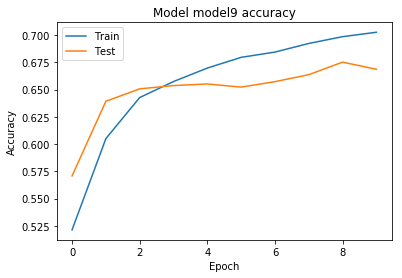

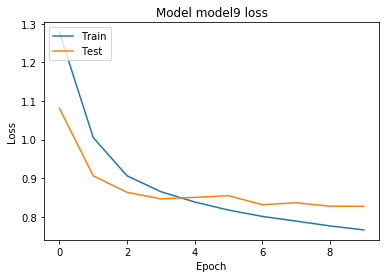

15606/15606 [==============================] - 3s 172us/step
validation scores for model9
loss score: 0.833715
acc score: 0.666603


In [26]:
from keras.layers import CuDNNLSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, Activation, Conv1D, MaxPooling1D
from keras import regularizers
from keras.callbacks import ModelCheckpoint

def build_model_v9(vocab_size, max_length,
                   embedding_dims=100,
                   embedding_matrix=None,
                   n_classes=n_classes,
                   rnn_units=128,
                   dropout=0.5,
                   loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['acc']):
    inputs = Input(shape=(max_length,))
    
    trainable=True
    embedding_initializer='uniform'
    if embedding_matrix is not None:
        trainable=False
        embedding_initializer=Constant(embedding_matrix)
    
    x = Embedding(vocab_size,
                  embedding_dims,
                  input_length=max_length,
                  trainable=trainable,
                  embeddings_initializer=embedding_initializer)(inputs)
    x = SpatialDropout1D(dropout)(x)
    
    x = Bidirectional(CuDNNLSTM(rnn_units, return_sequences=True))(x)    
    x = Conv1D(256, kernel_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.5)(x)
    
    x = Conv1D(128, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.5)(x)

    x = Conv1D(64, kernel_size=2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D()(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(100, kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(n_classes, activation = 'softmax')(x)

    model = Model(inputs=[inputs], outputs=x)
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=metrics)
    
    return model

model9 = build_model_v9(len(tokenizer.word_index),
                        seq_max_length,
                        embedding_dims=100,
                        rnn_units=128,
                        dropout=0.7)
model9.summary()

filepath="model9.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

train_model('model9', model9, 
            train_seq, y_train, test_seq, y_test, val_seq, y_val,
            callbacks=[checkpoint],
            class_weight=weights,
            epochs=10,
            batch_size=25,
            save=False)

In [27]:
train_model('model9', model9, 
            train_seq, y_train, test_seq, y_test, val_seq, y_val,
            initial_epoch=10,
            callbacks=[checkpoint],
            class_weight=weights,
            epochs=15,
            batch_size=25,
            save=False)

Train on 124848 samples, validate on 15606 samples
Epoch 11/15
124848/124848 [==============================] - 106s 852us/step - loss: 0.7568 - acc: 0.7094 - val_loss: 0.8312 - val_acc: 0.6695

Epoch 00011: val_acc did not improve from 0.67525
Epoch 12/15
 72675/124848 [================>.............] - ETA: 42s - loss: 0.7471 - acc: 0.7120

KeyboardInterrupt: 

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression
# from scipy import sparse
# from sklearn.preprocessing import StandardScaler
# from nltk.corpus import stopwords

# cv = CountVectorizer(min_df=5, max_df=0.8, ngram_range=(1,3), stop_words=stopwords.words('english'))
# x = cv.fit_transform(train['CleanedPhrase'])
# print('Shape of phrases: ', x.shape)

# # add number of tokens
# tokens = train['Tokens'].values.reshape((-1,1))
# x = sparse.hstack((x, tokens))

# print('Shape of new x: ', x.shape)

# # standardize values
# # scaler = StandardScaler(with_mean=False)
# # x = scaler.fit_transform(x)

# # add full sentence
# # full = train['Full'].values.reshape((-1,1))
# # x = sparse.hstack((x, full))
# # print('Shape of training data: ', x.shape)

# param_grid = {'C': [0.01, 0.1, 1, 10]}
# grid = GridSearchCV(LogisticRegression(verbose=10), param_grid, cv=5, n_jobs=-1, verbose=100)
# grid.fit(x, labels)

# print("Best cross-validation score: {:.2f}".format(grid.best_score_))
# print("Best parameters: ", grid.best_params_)
# print("Best estimator: ", grid.best_estimator_)

In [ ]:
# import mglearn

# feature_names = cv.get_feature_names()
# feature_names = np.append(feature_names, np.array(['<length>', '<full sentence>']))

# for cls, coefs in enumerate(grid.best_estimator_.coef_):
#     mglearn.tools.visualize_coefficients(coefs, feature_names, n_top_features=25)
#     plt.show()

# # y_pred = classifier.predict(x_t)  

# # print(confusion_matrix(y_test,y_pred))  
# # print(classification_report(y_test,y_pred))  
# # print(accuracy_score(y_test, y_pred)) 

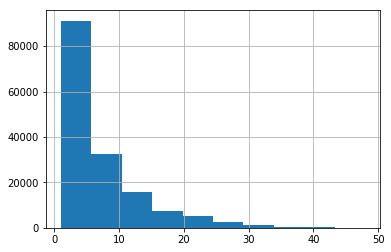

In [19]:
train['Tokens'].hist()

In [28]:
train['Tokens'].max()

48

In [31]:
train.head(200)

,PhraseId,SentenceId,Phrase,CleanedPhrase,Tokens,Full
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",a series of escapades demonstrating the adage that what is good for the goose is also good for the gander some of which occasionally amuses but none of which amounts to much of a story,35,True
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,a series of escapades demonstrating the adage that what is good for the goose,14,False
2,3,1,A series,a series,2,False
3,4,1,A,a,1,False
4,5,1,series,series,1,False
5,6,1,of escapades demonstrating the adage that what is good for the goose,of escapades demonstrating the adage that what is good for the goose,12,False
6,7,1,of,of,1,False
7,8,1,escapades demonstrating the adage that what is good for the goose,escapades demonstrating the adage that what is good for the goose,11,False
8,9,1,escapades,escapades,1,False
9,10,1,demonstrating the adage that what is good for the goose,demonstrating the adage that what is good for the goose,10,False
